In [67]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import pathlib
from PIL import Image

In [68]:
!pip install ultralytics

In [69]:
# Load the data
data = pd.read_csv('/kaggle/input/hw-ucu-12023-4-100-sports-image-classification/release_data.csv')
img_size = (224, 224)
num_classes = 100 

In [70]:
data

,class id,label,filename,subset
0,-1,NaN,0002c1ee-f7d6-4173-848a-1c33271e5883.jpg,test
1,29,figure skating women,00031336-d9f8-4b93-951c-910a3b899604.jpg,train
2,67,rock climbing,0009d277-8abf-40a1-8a74-78951607df62.jpg,train
3,64,polo,000da0fa-dc5c-4fa5-b693-0bbccc967a4a.jpg,train
4,7,baseball,000ddd9d-b232-4472-bcb7-f9c0d4e275f7.jpg,train
...,...,...,...,...
14488,62,pole dancing,ffeca2f4-abf3-451d-80e5-169fa50276a7.jpg,train
14489,99,wingsuit flying,ffef17f7-346c-49d9-899d-07227e9def32.jpg,train
14490,38,hang gliding,fff5569b-4f4c-47f5-89ee-e569da03a51b.jpg,train
14491,74,shuffleboard,fff8eb63-86a9-451b-8740-b514902b5c39.jpg,train


In [71]:
label_id_dict = dict(zip(data['class id'], data['label']))

In [72]:
# Check if all images have the same size
def check_image_sizes(directory, expected_size):
    different_size_images = []

    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            file_path = os.path.join(directory, filename)
            with Image.open(file_path) as img:
                if img.size != expected_size:
                    different_size_images.append(filename)

    return different_size_images

images_with_different_size = check_image_sizes(directory_path,img_size)

print("Images with different sizes:", images_with_different_size)


Images with different sizes: []


In [73]:
# Check if all images are valid
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()
        return True
    except (IOError, SyntaxError):
        return False

base_path = directory_path
filenames = os.listdir(directory_path)
invalid_files = [f for f in filenames if not is_valid_image(os.path.join(base_path, f))]

print(invalid_files)

['22d685d4-7505-493f-9820-8a73316f65fd.lnk']


In [74]:
data = data[data['filename'] != invalid_files[0]]

Divide into training and test sets

In [75]:
train = data[data['subset'] == 'train']

In [76]:
test = data[data['subset'] == 'test']

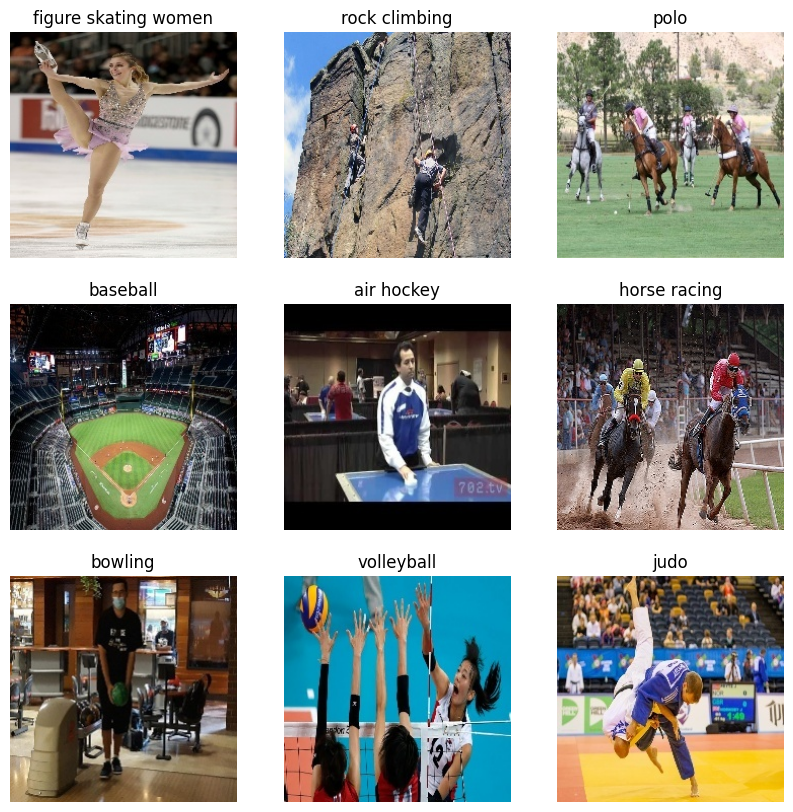

In [77]:
class_names = set(train.label)
directory_path = '/kaggle/input/hw-ucu-12023-4-100-sports-image-classification/data/data/'
plt.figure(figsize=(10, 10))
for i, row in train.head(9).iterrows():
    ax = plt.subplot(3, 3, i)
    image_full_path = directory_path + row['filename'] 
    image = Image.open(image_full_path) 
    plt.imshow(image)
    plt.title(row['label'])
    plt.axis("off")


In [78]:
# Add data augmentation
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=img_size),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.1), 
        layers.RandomBrightness(factor=0.1), 
    ]
)


Divide into 3 subdirectories: train, validation and test

In [79]:
validation_split = 0.2

train['subset'] = np.where(np.random.rand(len(train)) < validation_split, 'validation', 'train')
data.update(train)

destination_directory = '/kaggle/working/sets'

for index, row in data.iterrows():
    class_label = str(row['label'])
    filename = row['filename']
    subset = row['subset']
   
    if class_label == '-1':
        subset = 'test'
        class_label = 'unknown'
        
    class_dir = os.path.join(destination_directory, subset, class_label)
    
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

    src_path = os.path.join(directory_path, filename)
    dst_path = os.path.join(class_dir, filename)
    shutil.copy(src_path, dst_path)


/tmp/ipykernel_47/1374305028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['subset'] = np.where(np.random.rand(len(train)) < validation_split, 'validation', 'train')


In [80]:
num_classes = 100
batch_size = 64
img_height = 224
img_width = 224

TRAIN_PATH = pathlib.Path("/kaggle/working/sets/train")
VAL_PATH = pathlib.Path("/kaggle/working/sets/validation")
# TEST_PATH = pathlib.Path("/kaggle/working/sets/test")

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_PATH,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = False)

Found 13456 files belonging to 100 classes.
Found 8444 files belonging to 100 classes.


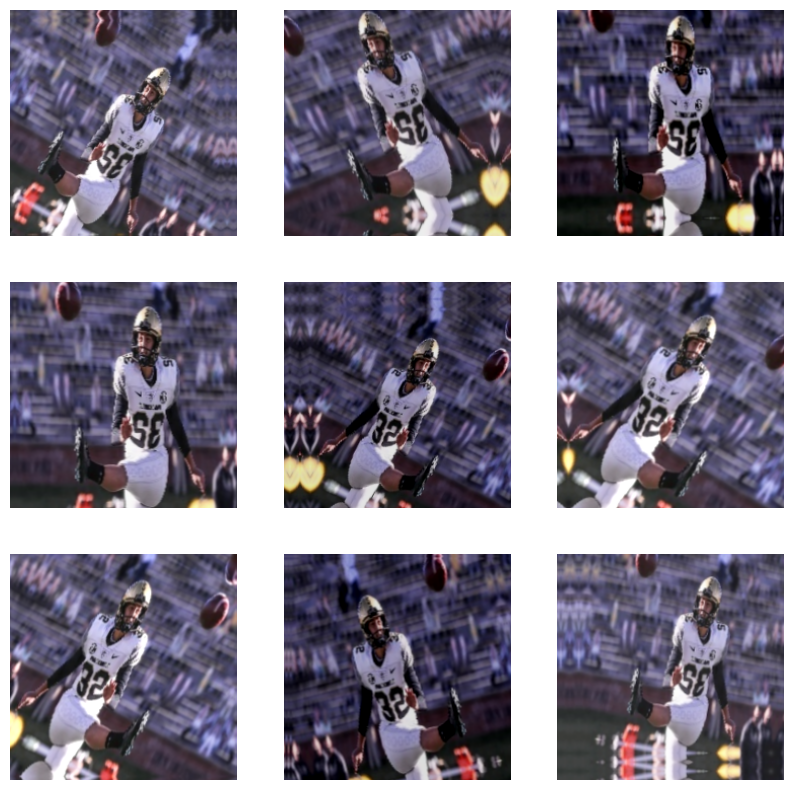

In [81]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[10].numpy().astype("uint8"))
    plt.axis("off")

CNN

In [82]:
model = Sequential([
  Rescaling(1./255, input_shape=(224, 224, 3)),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=20, validation_data=val_ds)
print("performance",model.evaluate(test_ds))
model.summary()

Epoch 1/20
211/211 [==============================] - 18s 75ms/step - loss: 4.2675 - accuracy: 0.0555 - val_loss: 3.6192 - val_accuracy: 0.1393
Epoch 2/20
211/211 [==============================] - 15s 71ms/step - loss: 3.1436 - accuracy: 0.2373 - val_loss: 2.4638 - val_accuracy: 0.3811
Epoch 3/20
211/211 [==============================] - 15s 70ms/step - loss: 2.2453 - accuracy: 0.4219 - val_loss: 1.6581 - val_accuracy: 0.5856
Epoch 4/20
211/211 [==============================] - 15s 71ms/step - loss: 1.4956 - accuracy: 0.6046 - val_loss: 1.0081 - val_accuracy: 0.7397
Epoch 5/20
211/211 [==============================] - 15s 70ms/step - loss: 0.8261 - accuracy: 0.7746 - val_loss: 0.6939 - val_accuracy: 0.8148
Epoch 6/20
211/211 [==============================] - 15s 70ms/step - loss: 0.4142 - accuracy: 0.8844 - val_loss: 0.4378 - val_accuracy: 0.8937
Epoch 7/20
211/211 [==============================] - 15s 70ms/step - loss: 0.2417 - accuracy: 0.9334 - val_loss: 0.3497 - val_accuracy:

Plot model accuracy

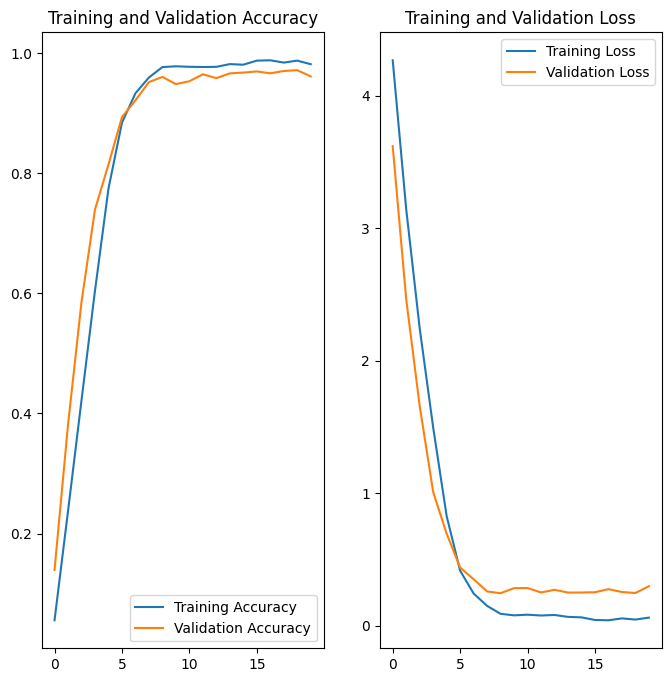

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Add augmented data to the train set

In [84]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

CNN with augmented data

In [85]:
model = Sequential([
  Rescaling(1./255, input_shape=(224, 224, 3)),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=10, validation_data=val_ds)
print("performance",model.evaluate(test_ds))
model.summary()

Epoch 1/20
211/211 [==============================] - 229s 1s/step - loss: 4.2800 - accuracy: 0.0465 - val_loss: 3.8268 - val_accuracy: 0.0973
Epoch 2/20
211/211 [==============================] - 228s 1s/step - loss: 3.5917 - accuracy: 0.1448 - val_loss: 3.4658 - val_accuracy: 0.1811
Epoch 3/20
211/211 [==============================] - 219s 1s/step - loss: 3.1887 - accuracy: 0.2188 - val_loss: 3.4353 - val_accuracy: 0.2006
Epoch 4/20
211/211 [==============================] - 228s 1s/step - loss: 2.9222 - accuracy: 0.2678 - val_loss: 2.8802 - val_accuracy: 0.2935
Epoch 5/20
211/211 [==============================] - 226s 1s/step - loss: 2.7188 - accuracy: 0.3071 - val_loss: 2.7584 - val_accuracy: 0.3095
Epoch 6/20
211/211 [==============================] - 227s 1s/step - loss: 2.5696 - accuracy: 0.3413 - val_loss: 2.8549 - val_accuracy: 0.3256
Epoch 7/20
211/211 [==============================] - 228s 1s/step - loss: 2.4707 - accuracy: 0.3684 - val_loss: 2.4181 - val_accuracy: 0.3835

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)


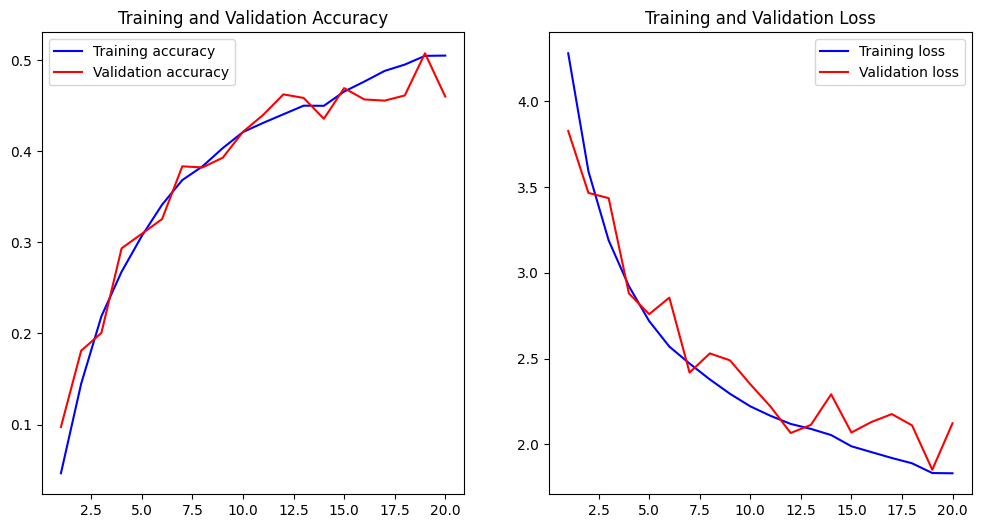

In [87]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


Resnet50

In [88]:
resnet_weights_path = 'imagenet'

In [89]:
resnet_model = Sequential()

resnet_model.add(ResNet50(include_top = False, pooling = 'avg',
                  weights = resnet_weights_path))


In [90]:
# resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(100, activation = 'softmax'))
resnet_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_10 (Dense)            (None, 100)               204900    
                                                                 
Total params: 23792612 (90.76 MB)
Trainable params: 23739492 (90.56 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [91]:
resnet_model.layers[0].trainable = False

In [92]:
sgd = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
resnet_model.compile(optimizer= sgd,
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [93]:
img_size = 224
batch_size= 20

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,            
    width_shift_range=0.2,     
    height_shift_range=0.2,     
    brightness_range=[0.8, 1.2], 
    fill_mode='nearest'  
)


val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)


test_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)


train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    target_size= (img_size, img_size),
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    class_mode ='categorical')

val_generator = val_datagen.flow_from_directory(VAL_PATH,
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                shuffle = False,
                                                class_mode ='categorical')

test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                shuffle = False,
                                                class_mode ='categorical')


Found 13456 images belonging to 100 classes.
Found 8444 images belonging to 100 classes.
Found 797 images belonging to 1 classes.


In [94]:
history = resnet_model.fit(train_generator,
                    validation_data = val_generator, epochs =10)


Epoch 1/10
673/673 [==============================] - 213s 311ms/step - loss: 1.6334 - accuracy: 0.6237 - val_loss: 0.4998 - val_accuracy: 0.8669
Epoch 2/10
673/673 [==============================] - 209s 310ms/step - loss: 0.9041 - accuracy: 0.7837 - val_loss: 0.4378 - val_accuracy: 0.8867
Epoch 3/10
673/673 [==============================] - 208s 309ms/step - loss: 0.6957 - accuracy: 0.8247 - val_loss: 0.3132 - val_accuracy: 0.9160
Epoch 4/10
673/673 [==============================] - 208s 309ms/step - loss: 0.6128 - accuracy: 0.8470 - val_loss: 0.3013 - val_accuracy: 0.9202
Epoch 5/10
673/673 [==============================] - 206s 306ms/step - loss: 0.5159 - accuracy: 0.8669 - val_loss: 0.2507 - val_accuracy: 0.9329
Epoch 6/10
673/673 [==============================] - 205s 304ms/step - loss: 0.4243 - accuracy: 0.8845 - val_loss: 0.2095 - val_accuracy: 0.9439
Epoch 7/10
673/673 [==============================] - 204s 303ms/step - loss: 0.4140 - accuracy: 0.8890 - val_loss: 0.1754 -

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

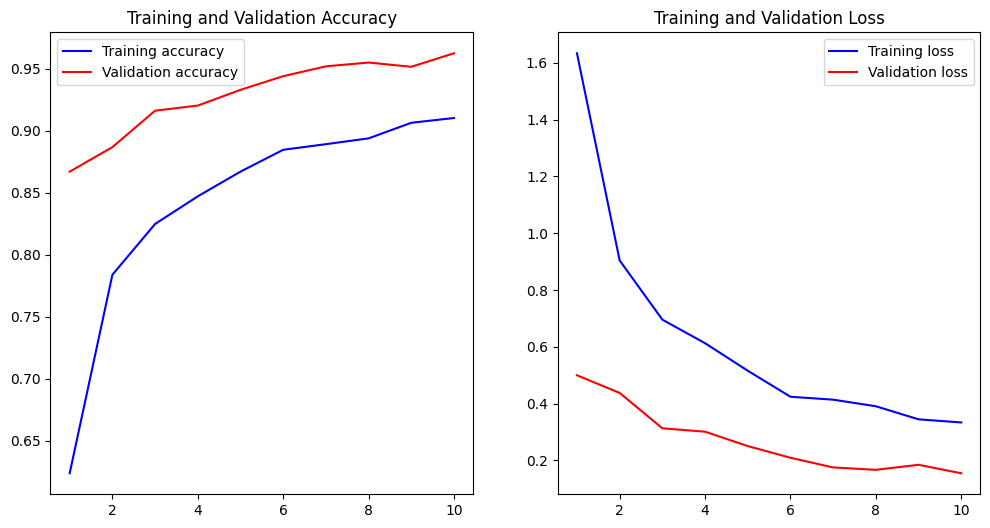

In [96]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [ ]:
# Parameter tuning for Resnet50

param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [5, 10],
    'learning_rate': [1e-4, 1e-3],
    'dropout_rate': [0.3, 0.5],
}

best_accuracy = 0
best_params = {}

for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for learning_rate in param_grid['learning_rate']:
            for dropout_rate in param_grid['dropout_rate']:
                
                train_generator = train_datagen.flow_from_directory(
                    TRAIN_PATH,
                    batch_size=batch_size,
                    class_mode='categorical')
                
                val_generator = val_datagen.flow_from_directory(
                    VAL_PATH,
                    batch_size=batch_size,
                    class_mode='categorical')
                
                model = create_model(dropout_rate)
                model.compile(optimizer=Adam(learning_rate=learning_rate),
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])
                
                history = model.fit(
                    train_generator,
                    validation_data=val_generator,
                    epochs=epochs,
                    verbose=0)
                
                val_accuracy = max(history.history['val_accuracy'])
                
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = {
                        'batch_size': batch_size,
                        'epochs': epochs,
                        'learning_rate': learning_rate,
                        'dropout_rate': dropout_rate
                    }
                print(f"Done with batch size {batch_size}, epochs {epochs}, learning rate {learning_rate}, dropout rate {dropout_rate}. Validation accuracy: {val_accuracy}")

print(f"Best validation accuracy of {best_accuracy} obtained with {best_params}")


Test on sample submission

In [98]:
sample_df = pd.read_csv('/kaggle/input/hw-ucu-12023-4-100-sports-image-classification/sample_submission.csv')

In [99]:
sample_df

,file_id,class_id
0,0002c1ee-f7d6-4173-848a-1c33271e5883,0
1,008a5ba9-db53-4f86-b934-a5cb7cacd068,0
2,00d589c8-9f2c-40f3-96b8-31e034ead422,0
3,00dd8596-4139-46e4-847e-9b52672673ca,0
4,019a49d4-38f5-4b0f-a7f1-759931a6fee8,0
...,...,...
792,fd9da67c-c8fe-4f78-a3a9-460eebe85276,0
793,fda31bf9-f130-4d4f-8643-7f0ac15642f5,0
794,fe2b81fb-3b90-404c-9014-0a8873f9cb15,0
795,fe6b0924-2cec-4f06-9ffa-0fa04186ab5f,0


In [106]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img_path = 'f554e71b-b1dc-44cb-b820-daef2efc3a43.jpg'
img_path =  base_path + img_path
img = load_img(img_path, target_size=(224, 224)) 
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array) 
predictions = resnet_model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

1/1 [==============================] - 1s 980ms/step


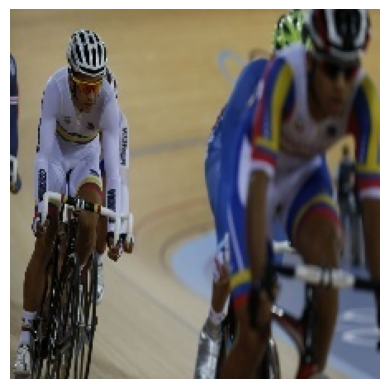

In [107]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
for index, row in sample_df.iterrows():
    origin_img_path = row['file_id']
    img_path =  base_path + origin_img_path + '.jpg'
    img = load_img(img_path, target_size=(224, 224)) 
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  
    predictions = resnet_model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    print(predicted_class)
    sample_df.at[index, 'class_id'] = predicted_class


YOLO

In [116]:
from ultralytics import YOLO

In [117]:
model = YOLO('yolov8x-cls.pt')

100%|██████████| 110M/110M [00:00<00:00, 250MB/s]  


In [ ]:
results = model.train(data='sets/', epochs=50, imgsz=224, optimizer='SGD')

In [ ]:
dict = predicted_class_name[0].names

In [ ]:
for index, row in sample_df.iterrows():
    origin_img_path = row['file_id']
    img_path =  directory_path + origin_img_path + '.jpg'
    predicted_class_name = model(img_path)
    predicted_class_id = predicted_class_name[0].probs.top1
    sample_df.at[index, 'class_id'] = predicted_class_id

#### 